https://distill.pub/2020/bayesian-optimization/
https://ax.dev/tutorials/saasbo_nehvi.html
https://botorch.org/v/0.2.3/tutorials/fit_model_with_torch_optimizer
https://pyro.ai/examples/bo.html

In [1]:
import math
import torch
import numpy as np


import matplotlib.pyplot as plt

from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan

c:\Users\MajidMortazavi\Git\productionOptimization\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

### Objective Function


In [35]:
# use regular spaced points on the interval [0, 1]
train_X = torch.linspace(0, 1, 10, dtype=dtype, device=device)
# training data needs to be explicitly multi-dimensional
train_X = train_X.unsqueeze(1)

# sample observed values and add some synthetic noise
train_Y = torch.sin(train_X * (2 * math.pi)) + 0.15 * torch.randn_like(train_X)

## Data

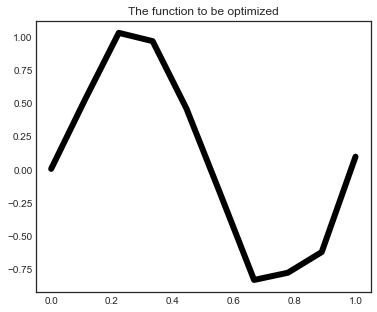

In [36]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(6, 5))
    plt.plot(train_X, train_Y, c='k', linewidth=6)
    plt.title('The function to be optimized')
    plt.show()

### Gaussian processes



In [37]:
model = SingleTaskGP(train_X=train_X, train_Y=train_Y)
model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

### Optimizing using expected improvement


In [38]:
from gpytorch.mlls import ExactMarginalLogLikelihood

mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
# set mll and all submodules to the specified dtype and device
mll = mll.to(train_X)

In [39]:
from torch.optim import SGD

optimizer = SGD([{'params': model.parameters()}], lr=0.1)

In [40]:
NUM_EPOCHS = 300

model.train()

for epoch in range(NUM_EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output MultivariateNormal
    output = model(train_X)
    # Compute negative marginal log likelihood
    loss = - mll(output, model.train_targets)
    # back prop gradients
    loss.backward()
    # print every 10 iterations
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} "
            f"lengthscale: {model.covar_module.base_kernel.lengthscale.item():>4.3f} " 
            f"noise: {model.likelihood.noise.item():>4.3f}" 
         )
    optimizer.step()

Epoch  10/300 - Loss: 2.202 lengthscale: 0.631 noise: 2.004
Epoch  20/300 - Loss: 2.161 lengthscale: 0.576 noise: 1.866
Epoch  30/300 - Loss: 2.123 lengthscale: 0.533 noise: 1.728
Epoch  40/300 - Loss: 2.085 lengthscale: 0.499 noise: 1.589
Epoch  50/300 - Loss: 2.049 lengthscale: 0.472 noise: 1.451
Epoch  60/300 - Loss: 2.012 lengthscale: 0.449 noise: 1.315
Epoch  70/300 - Loss: 1.974 lengthscale: 0.431 noise: 1.182
Epoch  80/300 - Loss: 1.935 lengthscale: 0.415 noise: 1.053
Epoch  90/300 - Loss: 1.894 lengthscale: 0.402 noise: 0.930
Epoch 100/300 - Loss: 1.853 lengthscale: 0.390 noise: 0.814
Epoch 110/300 - Loss: 1.811 lengthscale: 0.380 noise: 0.706
Epoch 120/300 - Loss: 1.768 lengthscale: 0.370 noise: 0.608
Epoch 130/300 - Loss: 1.725 lengthscale: 0.360 noise: 0.520
Epoch 140/300 - Loss: 1.682 lengthscale: 0.350 noise: 0.442
Epoch 150/300 - Loss: 1.639 lengthscale: 0.341 noise: 0.373
Epoch 160/300 - Loss: 1.596 lengthscale: 0.333 noise: 0.314
Epoch 170/300 - Loss: 1.554 lengthscale:

In [41]:
# set model (and likelihood)
model.eval();

### Define an acquisition function¶


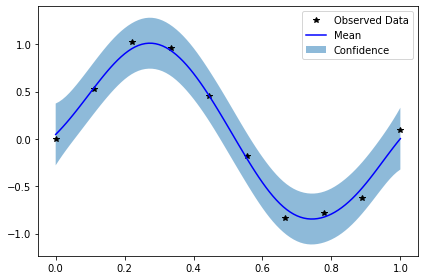

In [42]:
from matplotlib import pyplot as plt
%matplotlib inline

# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 1]
test_X = torch.linspace(0, 1, 101, dtype=dtype, device=device)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_X)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), 'k*')
    # Plot posterior means as blue line
    ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()

## Interfacing with Ax

In [74]:
def get_and_fit_model(Xs, Ys, **kwargs):
    
    model = SingleTaskGP(train_X=Xs, train_Y=Ys)
    model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

    mll = ExactMarginalLogLikelihood(model.likelihood, model).to(Xs)
    model.train()
    
    optimizer = SGD([{'params': model.parameters()}], lr=kwargs.get("lr"))
    for epoch in range(kwargs.get("epochs")):
        optimizer.zero_grad()
        output = model(Xs)
        loss = -mll(output, model.train_targets)
        loss.backward()
        optimizer.step()
    
    return model

In [75]:
model_ax = get_and_fit_model(train_X, train_Y, epochs=300, lr=0.1)

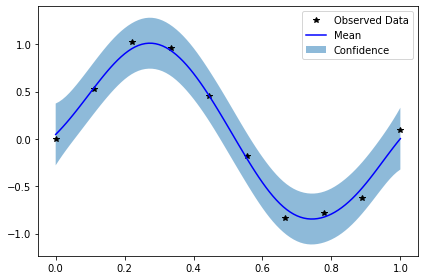

In [76]:
from matplotlib import pyplot as plt
%matplotlib inline

# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 1]
test_X = torch.linspace(0, 1, 101, dtype=dtype, device=device)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model_ax.posterior(test_X)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), 'k*')
    # Plot posterior means as blue line
    ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()